<a href="https://colab.research.google.com/github/khalil-alexander/get_forecast/blob/main/FutureVauleofISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis the movement of ISS using synthetic data**

## <font color="red"> Install Moudles in google colab <font/>

In [1]:
!pip install country_converter
!pip install shapely
!pip install cartopy
!pip install geopandas
!pip install movingpandas
!pip install hvplot
!pip install holoviews
!pip install geoviews
!pip install global_land_mask
!pip install reverse_geocode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 998.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.2/161.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.2/563.2 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 71.5 MB/s eta 0:00:00
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.6.1
    Uninstalling bokeh-3.6.1:
      Successfully uninstalled bokeh-3.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.8 MB/s eta 0:00:00


In [2]:
!pip install reverse_geocode

##<font color="red"> Import Modules <font/>

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import requests as reqs
import json
import xarray as xr
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from geopy.geocoders import Nominatim

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as mcm

In [6]:
import cartopy
import cartopy.crs as ccrs
import country_converter as coco
from cartopy.feature.nightshade import Nightshade
from global_land_mask import globe

In [7]:
from shapely import geometry as shpgeom
from shapely import wkt as shpwkt

In [8]:
import holoviews as hv
import hvplot.pandas
import geoviews

In [9]:
import os
from pathlib import Path
import datetime as dt
from datetime import timezone

In [10]:
from global_land_mask import globe
import reverse_geocode

## <font color="red"> Read Future Locations of ISS</font>

<font color="blue">We cannot determine yet future locations of ISS. Here, we want to use past locations to create synthetic data for our analysis.<font/>

<font color="blue">Read a file containing past locations of ISS.<font/>

In [11]:
file_name = "https://raw.githubusercontent.com/khalil-alexander/get_forecast/refs/heads/main/future_location.csv"
df = pd.read_csv(file_name)
df = df.head(500)

## <font color="red"> Create future dates</font>
- <font color="blue">Use Pandas to create a series of dates every seven seconds

In [12]:
# String of the current time of day now
start_date = dt.datetime.now() + dt.timedelta(days=1)

In [13]:
# Turns the date from a string object to a datetime object
start_date = start_date.strftime("%m/%d/%Y %H:%M:%S")

In [14]:
df_dates = pd.date_range(start=start_date, freq='7s', periods=len(df))

### <font color="green">Add a new columns containing the dates <font/>

In [15]:
df['t'] = df_dates

In [16]:
df

,latitude,longitude,t
0,-36.9477,-63.3776,2024-11-13 17:41:27
1,-37.1914,-63.0247,2024-11-13 17:41:34
2,-37.4542,-62.6395,2024-11-13 17:41:41
3,-37.6752,-62.3114,2024-11-13 17:41:48
4,-37.8953,-61.9813,2024-11-13 17:41:55
...,...,...,...
495,36.4992,104.1841,2024-11-13 18:39:12
496,36.7252,104.5043,2024-11-13 18:39:19
497,36.9502,104.8266,2024-11-13 18:39:26
498,37.1945,105.1805,2024-11-13 18:39:33


### <font color="green"> Get land_flag with the following:<font/>
<font color="blue">create get_land_flag function the with parameters<font/>
 - <font color="blue">latitude
 - longitude<font/>

In [17]:
# Writing a function to return if there is land in a given latitude/longitude
# Function returns 1 if there is land and returns 0 if there is ocean.
def get_land_flag(row):
    """
    Extract the land_flag given the latitude/longitude information.
    This function provides if there is land in a given latitude/longitude. If
    not then we can assume the given latitude/longitude is on the ocean.

    Parameters
    ----------
    lat : float
       Latitude of the location
    lon : float
       Longitude of the location

    Returns
    -------
    land_flag : boolen
       If land_flag is true or not
    """
    land_flag = globe.is_land(row['latitude'],row['longitude'])
    return land_flag

In [18]:
#Apply function to add land flag to the dataframe
%time df['land_flag'] = df.apply(get_land_flag, axis=1, result_type='expand')

CPU times: user 158 ms, sys: 0 ns, total: 158 ms
Wall time: 182 ms


In [19]:
df

,latitude,longitude,t,land_flag
0,-36.9477,-63.3776,2024-11-13 17:41:27,True
1,-37.1914,-63.0247,2024-11-13 17:41:34,True
2,-37.4542,-62.6395,2024-11-13 17:41:41,True
3,-37.6752,-62.3114,2024-11-13 17:41:48,True
4,-37.8953,-61.9813,2024-11-13 17:41:55,True
...,...,...,...,...
495,36.4992,104.1841,2024-11-13 18:39:12,True
496,36.7252,104.5043,2024-11-13 18:39:19,True
497,36.9502,104.8266,2024-11-13 18:39:26,True
498,37.1945,105.1805,2024-11-13 18:39:33,True


### <font color="green"> Getting the country name from latitude/longitude <font/>
- <font color="blue">First function: get_country_name <font/>

   *  <font color="blue">gets the country name <font/>

- <font color="blue">Second function: obtain_country_name <font/>
  *  <font color="blue">Uses the land_flag function and uses the first function to add to the dataframe <font/>

In [20]:
# Getting the name of a country with latitude/longitude
# Returns the name of the country
def get_country_name(lat: float, lon: float) -> str:
    """
    Extract the country name given the latitude/longitude information.
    This function provides a country name even when a location is on
    the ocean. We wish it was not the case.

    Parameters
    ----------
    lat : float
       Latitude of the location
    lon : float
       Longitude of the location

    Returns
    -------
    country : str
       Country name (empty string if no country)
    """
    # Get location with geocode
    lat_lon = (lat, lon),
    loc_name = reverse_geocode.search(lat_lon)
    return loc_name[0].get('country', '')

In [21]:
get_country_name(40,-74)

'United States'

In [22]:
#def get_country(data):
#    geolocator = Nominatim(user_agent="my_geocoder")
#
#    if data['Land Flag'] == 1:
#        lat = data['latitude']
#        long = data['longitude']
#        # A geopy.location.Location object
#        place = geolocator.reverse((lat, long))#, language='en')
        # A dictionary of the place including country and city
#        address = place.raw['address']
#        country = address['country']
#        return country
#    else:
#        return "Ocean"


In [44]:
# Using the function get_county_name we obtain the country if land_flag is true
# Returns name of country if land_flag is true, otherwise returns 'Ocean'
def obtain_country_name(row):
    """
    Extract the country name given the latitude/longitude information.
    This function provides a country name even when a location is on
    the ocean. We wish it was not the case.

    Parameters
    ----------
    lat : float
       Latitude of the location
    lon : float
       Longitude of the location

    Returns
    -------
    country : str
       Country name (empty string if no country)
    """

    if row['land_flag'] == 1:
        lat = row['latitude']
        lon = row['longitude']
        country = get_country_name(lat, lon)
        return country
    else:
        return "Ocean"

In [45]:
# Apply function that adds country name into the Dataframe
%time df['Country'] = df.apply(obtain_country_name, axis=1, result_type='expand')

CPU times: user 18.2 ms, sys: 29 µs, total: 18.2 ms
Wall time: 20.2 ms


In [46]:
df

,latitude,longitude,t,land_flag,surf_temp,cloud_cover,surf_press,rain,Country
0,-36.9477,-63.3776,2024-11-13 17:41:27,True,27.969083,51.812500,994.947333,0.0,Argentina
1,-37.1914,-63.0247,2024-11-13 17:41:34,True,27.807833,60.271667,994.645778,0.0,Argentina
2,-37.4542,-62.6395,2024-11-13 17:41:41,True,26.361056,60.440833,985.513694,0.0,Argentina
3,-37.6752,-62.3114,2024-11-13 17:41:48,True,24.439333,64.790000,962.012333,0.0,Argentina
4,-37.8953,-61.9813,2024-11-13 17:41:55,True,25.309583,38.479167,970.310972,0.0,Argentina
...,...,...,...,...,...,...,...,...,...
495,36.4992,104.1841,2024-11-13 18:39:12,True,3.169333,0.000000,829.538667,0.0,China
496,36.7252,104.5043,2024-11-13 18:39:19,True,2.134472,0.000000,829.403417,0.0,China
497,36.9502,104.8266,2024-11-13 18:39:26,True,1.468556,0.000000,819.074222,0.0,China
498,37.1945,105.1805,2024-11-13 18:39:33,True,2.397750,0.000000,797.636333,0.0,China


In [47]:
#help(get_weather_forecast)

In [48]:
#new_df = get_weather_forecast(40,-40)
#new_df

In [49]:
#def add_weather(x,y):
#    x['temperature'] = y['temperature_2m']
#    x['surface_pressure'] = y['surface_pressure']
#    x['total_cloud_cover'] = y['cloud_cover']
#    return x

In [50]:
#df = df.apply(local_weather_forecast, axis=1, args=[new_df])

# <font color="red">Weather forecast function <font/>

- <font color="blue"> 1. A function where you input Latitude and Longitude and returns weather forecast
- 2. A function where you input Pandas DataFrane and Date and returns an Xarry on the weather forecast
- 3. A Function where you use the first function to add the weather forecast to a Latiude and Longitude

In [51]:
# Obtaining weather forecast with web scraping and inputting latitude/longitude
def get_weather_forecast(lat: float, lon: float):
    """
    Do web scraping to obtain the weather forecast at any location
    (latutuude, longitude) around the world. This function returns the Pandas
    DataFrame containing a three-day weather forecast. The following parameters
    are Collected: Surface Temperature, Rain, Total Cloud Cover,
    Surface Pressure.

    Parameters
    ----------
    lat : float
        The latutude of the coordinate location
    lon : float
        The longitude of the coordinate location

    Return
    ------
    df : Pandas DataFrame
        The DataFrame containing the hourly data weather forecast.

    """
    # Make sure you input the Latitude Range is between [-90,90]
    # Make sure the longituide range is between [-180,180]

    if lat < -90 or lat > 90:
      return "Error"
    if lon < -180 or lon > 180:
      return "Error"

    # Web scraping
    # Access the webpage containing the three-day weather forecast

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
      "latitude": lat,
      "longitude": lon,
      "hourly": ["temperature_2m", "rain", "surface_pressure", "cloud_cover"],
      "forecast_days": 3
      }
    responses = reqs.get(url, params=params)
    # Load the content of the webpage in a json object
    json_page = json.loads(responses.text)

    # Extracting the forecast from the "hourly" portion of the json object
    # To obtain a dictionary
    data = json_page["hourly"]

    # Load data into a Pandas DataFrame )
    df = pd.DataFrame(data)

    # Convert the "time" collum into a datetime object
    # Make it the index of the DataFrame
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M')
    df.set_index("time",inplace=True)

    return df

In [52]:
# Input pandas dataframe and string date to get the forecast in an xarray
def get_forecast(df,date):
    """
    First the string "date" will be convered to daratime. You will be
    To get the following parameters in a specfic time up to the minute:Surface
    Temperature, Rain, Total Cloud Cover, Surface Pressure.

    Parameters
    ----------
    df : Pandas Dataframe
        A dataframe that holds the Surface Temperature, Rain, Total Cloud Cover,
        Surface Pressure. The index in represented in timeseries for every hour
        in the next three days.
    date : string
        A string that contains the date you wish to pull the weather forecast
        from. It will be in the format "Year-Month-Day Hour:Minute"

    Return
    ------
    ds : Xarray
        The Xarray containing the collected following weather forecasts:
        Surface Temperature, Rain, Total Cloud Cover, Surface Pressure.

    """

    # Converts the variable "Date" from a String to a DateTime object.
    if isinstance(date, str):
        date = pd.to_datetime(date, format='%Y-%m-%d %H:%M')

    # Converts the Pandas Dataframe into an Xarray
    ds = df.to_xarray()

    #Converts the hourly  DateTime object to an Xarray object which return a more percise time with it's weather conditions
    var = ds.interp(time=date)


    # Returns the weather forecasts: Surface Temperature, Rain, Total Cloud Cover, Surface Pressure in the form of a Tuple
    return var.temperature_2m.values[()], var.cloud_cover.values[()], var.surface_pressure.values[()], var.rain.values[()]

In [53]:
def local_weather_forecast(row):
    """
    First the string "date" will be convered to daratime. You will be
    To get the following parameters in a specfic time up to the minute:Surface
    Temperature, Rain, Total Cloud Cover, Surface Pressure.

    Parameters
    ----------
    lat : float
        The latutude of the coordinate location
    lon : float
        The longitude of the coordinate location

    Return
    ------
    ds : Xarray
        The Xarray containing the collected following weather forecasts:
        Surface Temperature, Rain, Total Cloud Cover, Surface Pressure.

    """
    #lat = row['latitude']
    #lon = row['longitude']
    #date = row['t']
    df2 = get_weather_forecast(row['latitude'], row['longitude'])
    return get_forecast(df2, row['t'])

Use the apply function to expand the orginal dataframe with latitude, longitude, and time with the new dataframe of weather forecasts

In [54]:
# Apply function that adds weather forecast
%time df[['surf_temp', 'cloud_cover', 'surf_press', 'rain']] = df.apply(local_weather_forecast, axis=1, result_type='expand')


CPU times: user 10.5 s, sys: 493 ms, total: 11 s
Wall time: 2min 31s


In [69]:
df

,latitude,longitude,t,land_flag,surf_temp,cloud_cover,surf_press,rain,Country
0,-36.9477,-63.3776,2024-11-13 17:41:27,True,27.969083,51.812500,994.947333,0.0,Argentina
1,-37.1914,-63.0247,2024-11-13 17:41:34,True,27.807833,60.271667,994.645778,0.0,Argentina
2,-37.4542,-62.6395,2024-11-13 17:41:41,True,26.361056,60.440833,985.513694,0.0,Argentina
3,-37.6752,-62.3114,2024-11-13 17:41:48,True,24.439333,64.790000,962.012333,0.0,Argentina
4,-37.8953,-61.9813,2024-11-13 17:41:55,True,25.309583,38.479167,970.310972,0.0,Argentina
...,...,...,...,...,...,...,...,...,...
495,36.4992,104.1841,2024-11-13 18:39:12,True,3.169333,0.000000,829.538667,0.0,China
496,36.7252,104.5043,2024-11-13 18:39:19,True,2.134472,0.000000,829.403417,0.0,China
497,36.9502,104.8266,2024-11-13 18:39:26,True,1.468556,0.000000,819.074222,0.0,China
498,37.1945,105.1805,2024-11-13 18:39:33,True,2.397750,0.000000,797.636333,0.0,China


## <font color="red">GeoPandas <font/>

###<font color="green">Geopandas read url of a world map <font/>

In [56]:
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
gdf_world = gpd.read_file(url)

<Axes: >

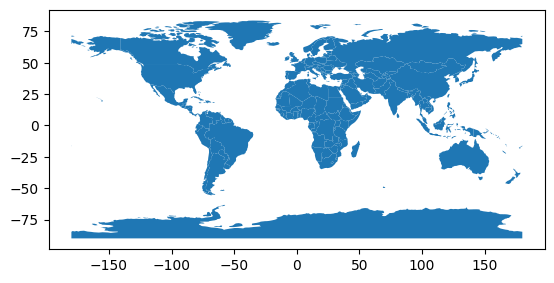

In [57]:
gdf_world.plot()

### <font color="green">Convert the iss Dataframe to a GeoDataframe<font/>

In [58]:
# Turning the Pandas Dataframe into a GeoPandas Dataframe
future_iss_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [59]:
future_iss_gdf

,latitude,longitude,t,land_flag,surf_temp,cloud_cover,surf_press,rain,Country,geometry
0,-36.9477,-63.3776,2024-11-13 17:41:27,True,27.969083,51.812500,994.947333,0.0,Argentina,POINT (-63.3776 -36.9477)
1,-37.1914,-63.0247,2024-11-13 17:41:34,True,27.807833,60.271667,994.645778,0.0,Argentina,POINT (-63.0247 -37.1914)
2,-37.4542,-62.6395,2024-11-13 17:41:41,True,26.361056,60.440833,985.513694,0.0,Argentina,POINT (-62.6395 -37.4542)
3,-37.6752,-62.3114,2024-11-13 17:41:48,True,24.439333,64.790000,962.012333,0.0,Argentina,POINT (-62.3114 -37.6752)
4,-37.8953,-61.9813,2024-11-13 17:41:55,True,25.309583,38.479167,970.310972,0.0,Argentina,POINT (-61.9813 -37.8953)
...,...,...,...,...,...,...,...,...,...,...
495,36.4992,104.1841,2024-11-13 18:39:12,True,3.169333,0.000000,829.538667,0.0,China,POINT (104.1841 36.4992)
496,36.7252,104.5043,2024-11-13 18:39:19,True,2.134472,0.000000,829.403417,0.0,China,POINT (104.5043 36.7252)
497,36.9502,104.8266,2024-11-13 18:39:26,True,1.468556,0.000000,819.074222,0.0,China,POINT (104.8266 36.9502)
498,37.1945,105.1805,2024-11-13 18:39:33,True,2.397750,0.000000,797.636333,0.0,China,POINT (105.1805 37.1945)


### <font color="green"> Plot future ISS path <font/>

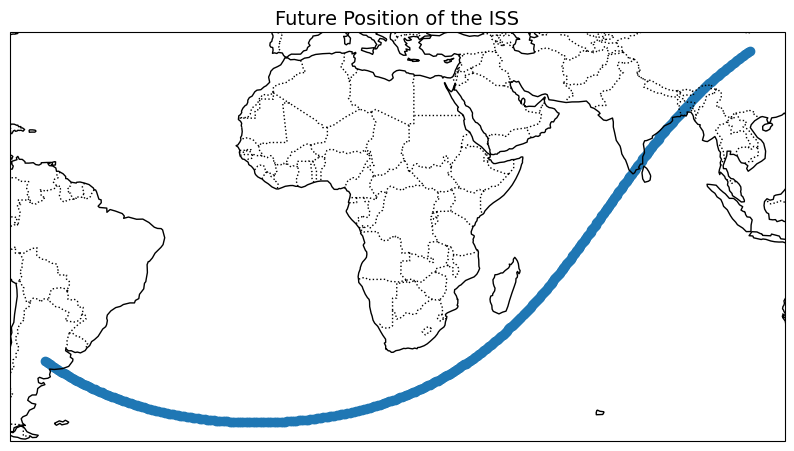

In [60]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
future_iss_gdf.plot(
    ax=ax
)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines()
plt.title('Future Position of the ISS', fontsize = 14);
plt.savefig('fig_iss_paths_no_countries')

### <font color="green"> Future Path of ISS by Longitude <font/>

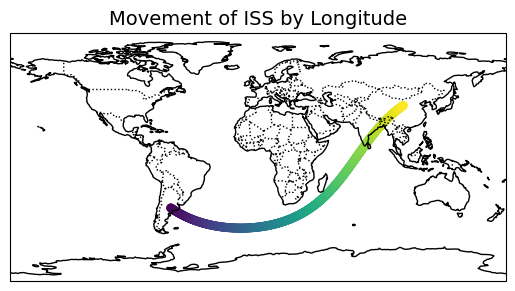

In [61]:
g, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 10)
future_iss_gdf.plot(column='longitude', ax=ax, linewidth=0.5)

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Longitude', fontsize = 14);

### <font color="green"> Plot GeoPandasDataframe ISS movement by country <font/>

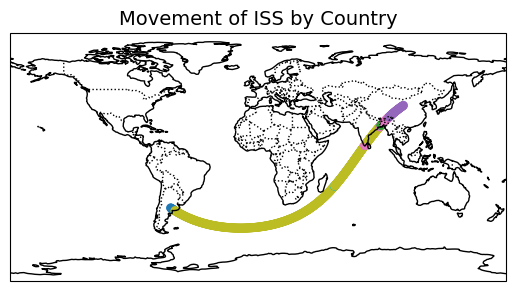

In [62]:
g, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 10)

future_iss_gdf.plot(column='Country', ax=ax, linewidth=0.5)

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Country', fontsize = 14);

In [63]:
future_iss_gdf

,latitude,longitude,t,land_flag,surf_temp,cloud_cover,surf_press,rain,Country,geometry
0,-36.9477,-63.3776,2024-11-13 17:41:27,True,27.969083,51.812500,994.947333,0.0,Argentina,POINT (-63.3776 -36.9477)
1,-37.1914,-63.0247,2024-11-13 17:41:34,True,27.807833,60.271667,994.645778,0.0,Argentina,POINT (-63.0247 -37.1914)
2,-37.4542,-62.6395,2024-11-13 17:41:41,True,26.361056,60.440833,985.513694,0.0,Argentina,POINT (-62.6395 -37.4542)
3,-37.6752,-62.3114,2024-11-13 17:41:48,True,24.439333,64.790000,962.012333,0.0,Argentina,POINT (-62.3114 -37.6752)
4,-37.8953,-61.9813,2024-11-13 17:41:55,True,25.309583,38.479167,970.310972,0.0,Argentina,POINT (-61.9813 -37.8953)
...,...,...,...,...,...,...,...,...,...,...
495,36.4992,104.1841,2024-11-13 18:39:12,True,3.169333,0.000000,829.538667,0.0,China,POINT (104.1841 36.4992)
496,36.7252,104.5043,2024-11-13 18:39:19,True,2.134472,0.000000,829.403417,0.0,China,POINT (104.5043 36.7252)
497,36.9502,104.8266,2024-11-13 18:39:26,True,1.468556,0.000000,819.074222,0.0,China,POINT (104.8266 36.9502)
498,37.1945,105.1805,2024-11-13 18:39:33,True,2.397750,0.000000,797.636333,0.0,China,POINT (105.1805 37.1945)


# <font color="red"> Add Nightshade plot <font/>


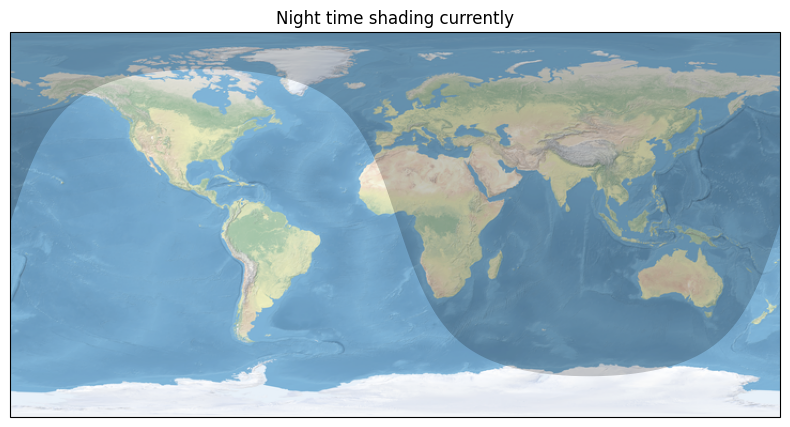

In [64]:

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#date = dt.datetime(1999, 12, 31, 12)

ax.set_title(f'Night time shading currently')
ax.stock_img()
ax.add_feature(Nightshade(future_iss_gdf.t[0], alpha=0.2))
plt.show()

### <font color="green"> Combine night time shade plot and iss path plot <font/>

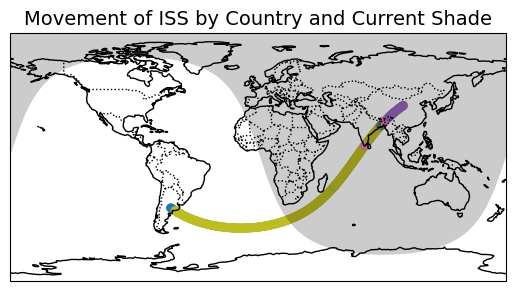

In [74]:
g, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 10)

future_iss_gdf.plot(column='Country', ax=ax, linewidth=0.5)

ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(Nightshade(future_iss_gdf.t[0], alpha=0.2))
ax.coastlines()
ax.set_global()
plt.title('Movement of ISS by Country and Current Shade', fontsize = 14);


# <font color="red"> Other code <font/>

In [ ]:
!pip install ocean-names

In [ ]:
from ocean_names import OceanNames

def get_ocean_name(lat, lon):
    ocean_info = OceanNames.reverse_geocode(lat=lat, lng=lon)
    if ocean_info:
        return ocean_info.get("name")
    else:
        return "Unknown"

latitude = 40.7128
longitude = -74.0060
ocean_name = get_ocean_name(latitude, longitude)
print(ocean_name)

In [ ]:
from geopy.geocoders import Nominatim

def get_sea_name(latitude, longitude):
    geolocator = Nominatim(user_agent="sea_finder")
    location = geolocator.reverse((latitude, longitude), language="en")
    print(location)

    if location is not None and "ocean" in location.raw["address"]:
        return location.raw["address"]["ocean"]
    elif location is not None and "sea" in location.raw["address"]:
        return location.raw["address"]["sea"]
    else:
        return "Unknown"

latitude = 45
longitude = -30
sea_name = get_sea_name(latitude, longitude)

print(sea_name)

In [ ]:
atlanticOcean = [(-24.6,68.5), (25.3,69.8), (5.7,61.4), (4.6,52.2), (-6.3,48.4),
            (-9.45,43.5), (-9.63,37.6), (-6.3,35.5), (-10.5,31.1), (-10.5,28.4),
            (-16.1,24.5), (-17.2,14.7), (-8.2,4.1), (6.3,3.6), (9.9,3.4),
            (9,-1.7), (13.8,-12.6), (11.7,-16.5), (14.5,-22.3), (16.1,-28.67),
            (18.9,-34.5), (18.9,-55.7), (-66,-55.7), (-68.5,-50.4), (-58.6,-39.3), (-48.1,-28.2),
            (-48.1,-25.7), (-41.6,-22.7), (-38.7,-17.4), (-39.5,-13.7), (-36.9,-12.5),
            (-34.9,-10.4), (-35.0,-5.5), (-50,-0.1), (-53,5.5), (-57.2,6.1),
            (-62.8,10.9), (-67.8,10.9), (-74.2,10.8), (-76.9,8.5), (-81.6,9.4),
            (-82.7,14), (-87.4,16.1), (-86.3,21.6), (-90.2,21.7), (-91.2,19.2),
            (-95.7,18.8), (-97.1,25.5), (-91.0,28.9), (-84,29.7), (-82.9,27.3),
            (-80.9,24.9), (-79.3,26.7), (-81.1,31.3), (-75.4,35.2), (-73.8,40.3),
            (-69.6,41.4), (-65.1,43.5), (-60,45.8), (-52.2,47.1), (-54.9,52.9),
            (-44.5,60.1), (-38.8,65.1)]

indianOcean =  [(21.40,-34.15), (27.37,-33.71), (40.03,-15.61), (39.68,-3.50), (51.80,10.16),
                (58.84,22.26), (65.69,25.18), (71.32,19.83), (77.47,6.86), (80.24,12.53),
                (80.90,15.85), (89.05,22.12), (91.38,22.08), (94.54,17.74), (94.02,16.02),
                (97.00,16.82), (98.19,8.33), (100.78,3.18), (94.98,6.29), (105.0,-6.52),
                (118.16,-9.26), (123.52,-11.25), (129.93,-11.08), (128.62,-14.51), (125.89,-3.57),
                 (118.51,-20.37), (113.06,-22.18), (115.26,-34.44), (123.52,-34.88), (130.99,-32.09),
                (137.23,-36.59), (137.50,-66.47), (102.26,-65.79), (85.65,-66.22), (75.01,-69.50),
                (69.04,-67.67), (54.18,-65.76), (37.48,-68.65)]

In [ ]:
pacificEast = [(149.9,-37.8),(153.9,-28.5),(143.2,-11.5),(152.1,-0.9),(127.9,5.7),
                (122.9,23.8),(123.4,31),(128.9,33.7),(129.8,29.4),(141.6,35),
                (142.8,41),(148,43.3),(144.6,45.5),(146.2,49.3),(144.9,54.2),
                (136.8,55.2),(143.1,59.1),(153.7,59.2),(159.4,61.6),(160.3,60.5),
                (161.4,60.3),(155.4,57),(156.6,50.3),(160.8,52.8),(164.1,55.8),
                (163.8,58.1),(167.3,60.1),(170.7,59.8), (179.9,-77.1),
                (166.4,-77.1), (173.8,-71.8), (142.9,-66.8), (146.9,-44.8)]

pacificWest = [(-179.9,62.2),(-179.7,64.7),
                (-177.3,65.3),(-173.6,63.4),(-166,62.2),(-165.8,60.9),(-168.4,60.4),
                (-166.6,58.9),(-158.5,57.8),(-153.1,57),(-144.8,59.9),(-136.1,56.9),
                (-131.7,51.9),(-125.2,48.4),(-124.5,44.6),(-124.4,40.7),(-117.6,32.7),
                (-110.7,23.2),(-105.8,19.7),(-96.1,15.3),(-87.9,12.4),(-83.7,7.3),
                (-78.7,6.1),(-80.2,0.9),(-82.2,-0.6),(-81.2,-6.3),(-76.7,-14.4),
                (-70.4,-18.9),(-73.7,-36.7),(-76,-46.2),(-75.1,-53),(-73.4,-55.1),
                (-66.6,-56.3),(-64.6,-55),(-59.6,-63.4),(-68.4,-65.7),(-75.8,-72.2),
                (-98.6,-71.8),(-126.8,-73.2),(-146.8,-75.7),(-162.6,-78.4),(-179.9,-77.1)]

In [ ]:
p1 = path.Path(atlanticOcean)
    p2 = path.Path(indianOcean)
    p3 = path.Path(pacificEast)
    p4 = path.Path(pacificWest)

    target = [(lon, lat)]

    result1 = p1.contains_points(target)
    result2 = p2.contains_points(target)
    result3 = p3.contains_points(target)
    result4 = p4.contains_points(target)

    # if target is in one of the polygons, it is in ocean
#    if result1==True or result2==True or result3==True or result4==True:
#        print("In Ocean")
#    else:
#        print("Land")